In [1]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler



import scipy.stats as stats

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [3]:
df_vehiculos = pd.read_csv('./data/MotorAlpes_data.csv', sep=',', encoding = 'utf-8')

In [4]:
df_vehiculos.shape

(7115, 12)

In [5]:
df_vehiculos.sample(5)

,Unnamed: 0,year,km_driven,owner,seller_type,seats,fuel,transmission,mileage,engine,max_power,selling_price
2997,3426,2018.0,2000.0,First Owner,Dealer,5.0,Diesel,Automatic,16.8,1984.0,150.00,29985.46
4241,4848,2008.0,80000.0,Fourth & Above Owner,Individual,5.0,Petrol,Manual,18.9,1061.0,1610.34,1332.69
6770,7737,2010.0,60000.0,Second Owner,Individual,5.0,Petrol,Manual,18.6,1199.0,79.40,1332.69
5985,6843,2014.0,77500.0,Second Owner,Individual,7.0,Diesel,Manual,14.0,2179.0,138.10,6542.28
2180,2499,2014.0,65000.0,First Owner,Individual,5.0,Diesel,Manual,25.2,1248.0,74.00,5149.02


## 2.  Entendimiento y limpieza de los datos

Una variable que siempre tiene que estar es `Selling_price`, ya que la intención de este modelo es identificar las variables que impactar el precio de un vehiculo usado. Así como predecir el precio de un vehiculo a partir de esas varibles que afectan el precio.

Para esto solo se ha seleccionado variables numericas.

In [6]:
variables_interes = ['year', 'km_driven', 'seats', 'mileage', 'engine','max_power','transmission','fuel','seller_type','owner']

df_vehiculos_t = df_vehiculos.copy()

In [7]:
df_vehiculos_t[['selling_price'] + variables_interes].isnull().sum() / df_vehiculos_t.shape[0]

selling_price    0.056360
year             0.033591
km_driven        0.027829
seats            0.000000
mileage          0.027829
engine           0.039353
max_power        0.037667
transmission     0.000000
fuel             0.000000
seller_type      0.000000
owner            0.033591
dtype: float64

In [8]:
encoder = LabelEncoder()
df_vehiculos_t["owner"] = encoder.fit_transform(df_vehiculos_t["owner"])
print(encoder.classes_)
df_vehiculos_t["seller_type"] = encoder.fit_transform(df_vehiculos_t["seller_type"])
print(encoder.classes_)

df_vehiculos_t["fuel"] = encoder.fit_transform(df_vehiculos_t["fuel"])
print(encoder.classes_)

df_vehiculos_t["transmission"] = encoder.fit_transform(df_vehiculos_t["transmission"])
print(encoder.classes_)

df_vehiculos_t.sample(5)



['First Owner' 'Fourth & Above Owner' 'Second Owner' 'Test Drive Car'
 'Third Owner' nan]
['Dealer' 'Individual' 'Trustmark Dealer']
['CNG' 'Diesel' 'LPG' 'Petrol']
['Automatic' 'Manual']


,Unnamed: 0,year,km_driven,owner,seller_type,seats,fuel,transmission,mileage,engine,max_power,selling_price
175,202,2014.0,60000.0,2,1,5.0,3,1,19.40,1198.0,86.8,3513.45
4573,5222,2012.0,30000.0,0,1,5.0,3,1,20.36,1197.0,78.9,3271.14
3116,3565,2018.0,15000.0,0,1,5.0,3,0,20.89,1197.0,81.8,7511.51
5737,6556,2017.0,45000.0,0,0,5.0,1,0,19.33,NaN,NaN,38769.08
4183,4785,2018.0,80000.0,0,1,5.0,1,1,17.10,1956.0,170.0,20293.19


## 2.1 Relaciones entre variables
A continuación vamos a visualizar la correlación entre selling price y las variables de interes.

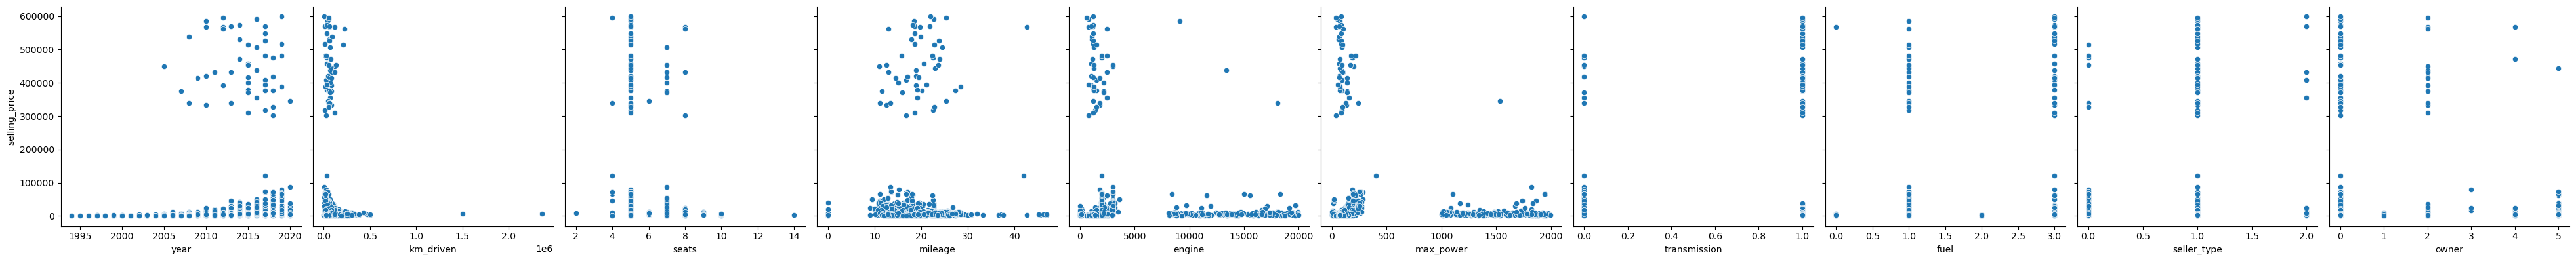

In [9]:
sns.pairplot(df_vehiculos_t, height = 4, y_vars = 'selling_price', x_vars = variables_interes, kind = 'scatter')
plt.show()

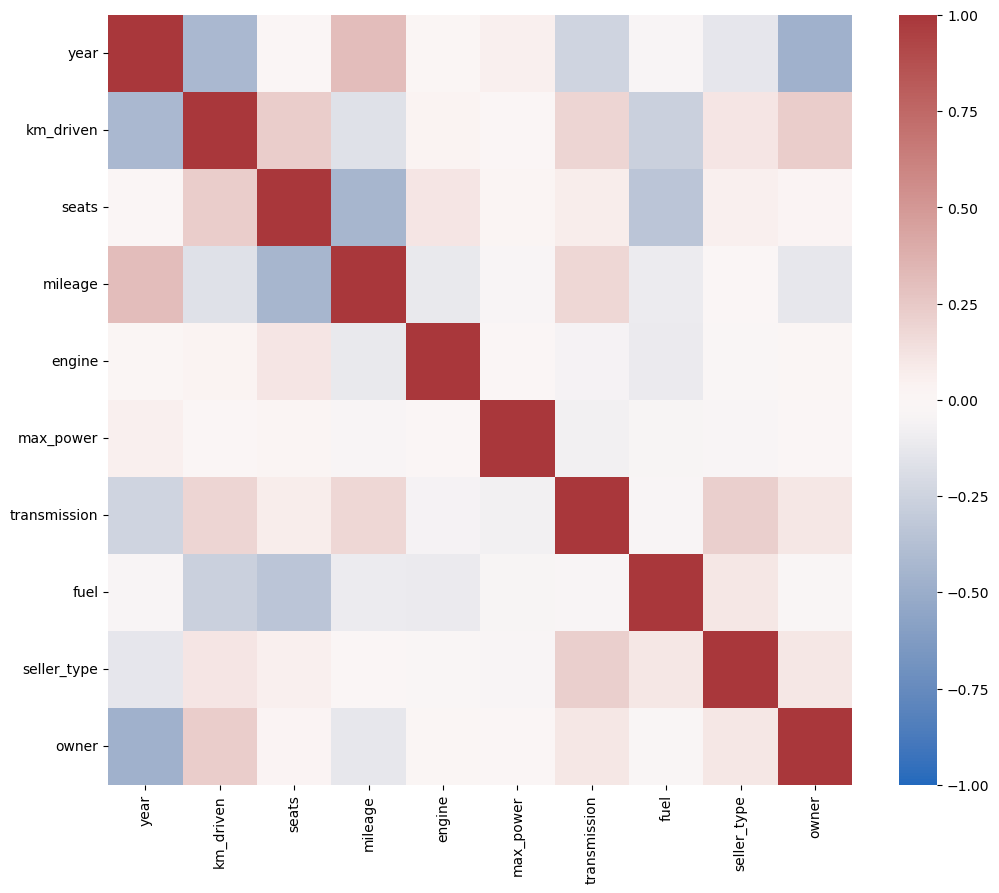

In [10]:
plt.figure(figsize = (12, 10))
sns.heatmap(df_vehiculos_t[variables_interes].corr(), cmap = 'vlag', vmin = -1, vmax = 1)
plt.show()

Cambio de los valores nulos por la media de los datos por cada columna

In [11]:
df_vehiculos_copy = df_vehiculos_t.copy()

In [12]:
def fill_na_all(df, var_to_transform):
    for i in var_to_transform:
        mean = df[i].mean()
        df[i]=df[i].fillna(mean)
    mean = df['selling_price'].mean()
    df['selling_price']=df['selling_price'].fillna(mean)
    return df
        

In [13]:
df_vehiculos_copy= fill_na_all(df_vehiculos_copy,variables_interes)

In [14]:
df_vehiculos_copy.sample(5)
df_vehiculos_copy[['selling_price'] + variables_interes].isnull().sum() / df_vehiculos_copy.shape[0]
#Se muestra que se ha pasado los nulos a valores promedio

selling_price    0.0
year             0.0
km_driven        0.0
seats            0.0
mileage          0.0
engine           0.0
max_power        0.0
transmission     0.0
fuel             0.0
seller_type      0.0
owner            0.0
dtype: float64

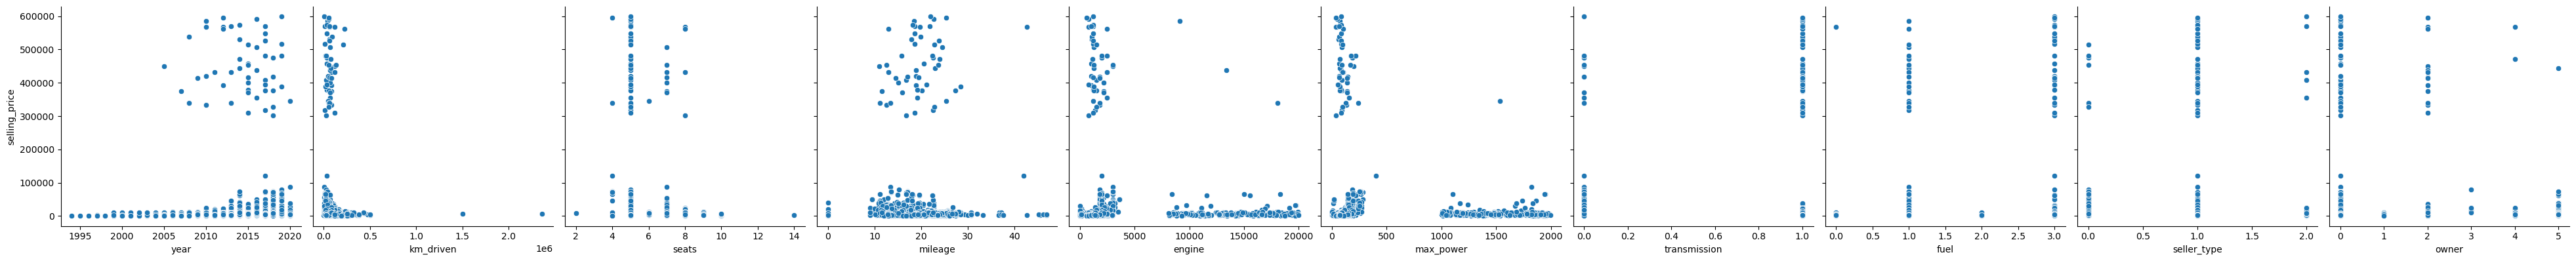

In [15]:
sns.pairplot(df_vehiculos_copy, height = 4, y_vars = 'selling_price', x_vars = variables_interes, kind = 'scatter')
plt.show()

## 3.Particionamiento del conjunto de datos.
Separación datos x y y para entrenamiento y x y y para test.

In [16]:
x_train, x_test, y_train,  y_test  = train_test_split(df_vehiculos_copy[variables_interes], df_vehiculos_copy['selling_price'], test_size=0.3, random_state=1)
x_train.shape, y_train.shape
x_test.shape, y_test.shape

((2135, 10), (2135,))

In [17]:
df_vehiculos_test_final = pd.read_csv('./data/MotorAlpes_test.csv', sep=',', encoding = 'utf-8')
X_test = df_vehiculos_test_final[variables_interes]
X_test.shape

(791, 10)

## 4. Entrenamiento de un primer modelo
Para este primer modelo solo se va a remplazar los valores nulos a la media  de todos los datos.

In [18]:
regression = LinearRegression()
regression.fit(x_train, y_train)

LinearRegression()

### 4.1 Interpretación de los coeficientes y del intercepto

En base a los coeficientes anteriormente mostrados, solo datos como engine, max_power, y km_driven tienen un coeficiente de puridad acceptablle .

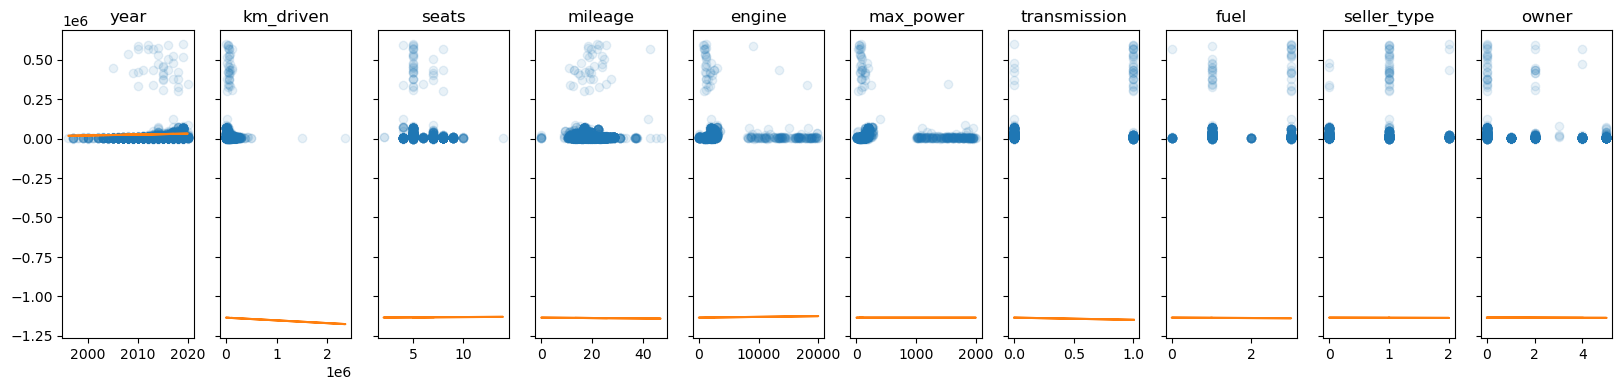

In [19]:
f, axs = plt.subplots(1, len(variables_interes), sharey = True, figsize = (20, 4))

for i in range(len(variables_interes)):
    col = variables_interes[i]
    x = x_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, 'o', alpha = 0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
plt.show()

In [20]:
pd.DataFrame({'columns': variables_interes, 'coef': regression.coef_})

,columns,coef
0,year,577.623848
1,km_driven,-0.017409
2,seats,352.109119
3,mileage,-127.275996
4,engine,0.481547
5,max_power,-0.126393
6,transmission,-13927.354637
7,fuel,-1271.633820
8,seller_type,-912.870651
9,owner,-286.577985


In [21]:
regression.intercept_

-1135577.0454661832

De lo anterior se puede interpretar que hay mukchos valores atipicos que no permiten detectar una relación lineal entre el precio y alguna de las caracteristicas.

## 4.2 Validación del modelo
### Mean Absolute Error


In [22]:
print('Train:', mean_absolute_error(y_train, regression.predict(x_train)))
print('Test:', mean_absolute_error(y_test, regression.predict(x_test)))

Train: 8551.217233036068
Test: 8609.721337252493


### Root Mean Squeared Error (RMSE)

In [23]:
 print('Train:', np.sqrt(mean_squared_error(y_train, regression.predict(x_train))))
print('Test:', np.sqrt(mean_squared_error(y_test, regression.predict(x_test))))

Train: 39324.01013474428
Test: 38255.19509447831


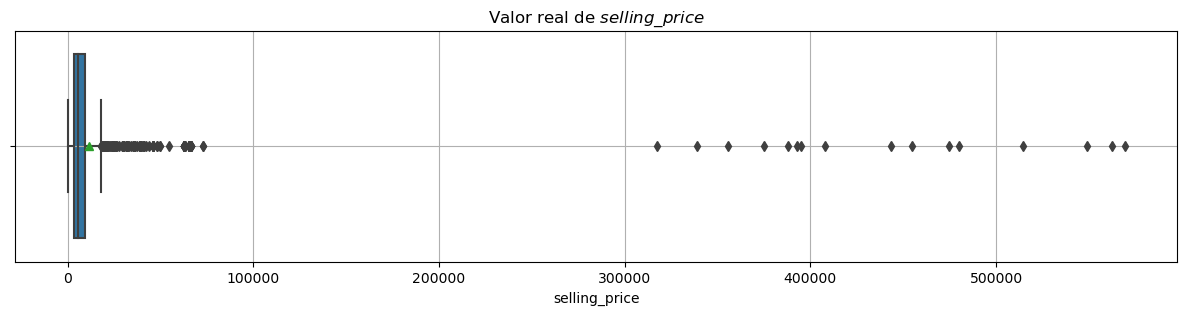

In [24]:
plt.figure(figsize = (15, 3))
sns.boxplot(x = y_test, showmeans = True, orient = 'h')
plt.title('Valor real de $\t{selling\_price}$')
plt.grid()
plt.show()

## 5. Entrenamiento 2do Modelo


In [25]:
def fill_outliers(df, var_to_transform):    
    q_low = df['selling_price'].quantile(0.25)
    q_hi  = df['selling_price'].quantile(0.75)
    iqr=q_hi-q_low
    maximus = q_hi-1.5*iqr
    minimus = q_low-1.5*iqr

    mean = df['selling_price'].mean()



    df = df.mask(df['selling_price']>maximus,q_hi)
    df = df.mask(df['selling_price']<minimus,q_low)
    return df
        
 

In [26]:
df_vehiculos_transformed=fill_outliers(df_vehiculos_copy,variables_interes)

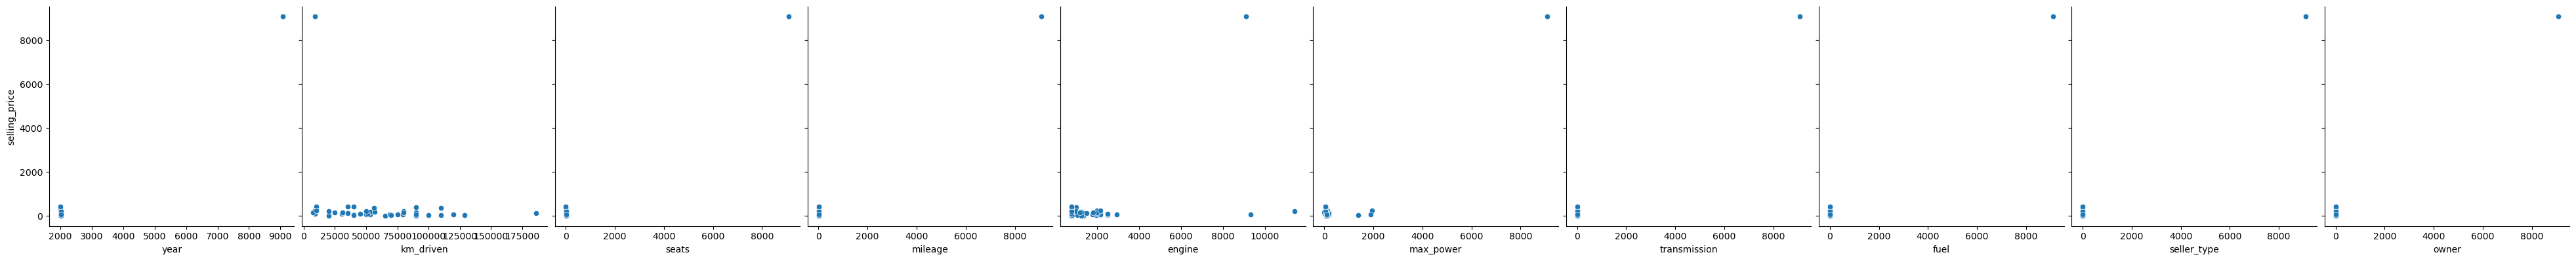

In [27]:
sns.pairplot(df_vehiculos_transformed, height = 4, y_vars = 'selling_price', x_vars = variables_interes, kind = 'scatter')
plt.show()

In [28]:
regression_2 = LinearRegression()
regression_2.fit(x_train, y_train)

LinearRegression()

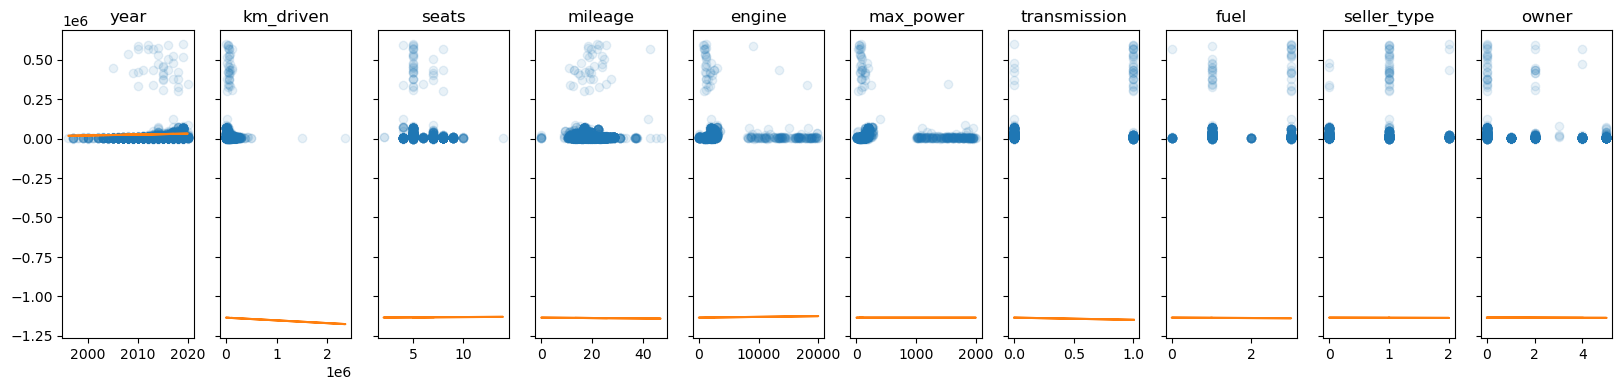

In [29]:
f, axs = plt.subplots(1, len(variables_interes), sharey = True, figsize = (20, 4))

for i in range(len(variables_interes)):
    col = variables_interes[i]
    x = x_train[col]
    m = regression_2.coef_[i]
    b = regression_2.intercept_

    axs[i].plot(x, y_train, 'o', alpha = 0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
plt.show()

In [30]:
regression_2.intercept_

-1135577.0454661832

In [31]:
pd.DataFrame({'columns': variables_interes, 'coef': regression_2.coef_})

,columns,coef
0,year,577.623848
1,km_driven,-0.017409
2,seats,352.109119
3,mileage,-127.275996
4,engine,0.481547
5,max_power,-0.126393
6,transmission,-13927.354637
7,fuel,-1271.633820
8,seller_type,-912.870651
9,owner,-286.577985


### 5.2 Validación 2do Modelo


#### Mean Absolute Error


In [43]:
print('Train:', mean_absolute_error(y_train, regression_2.predict(x_train)))
print('Test:', mean_absolute_error(y_test, regression_2.predict(x_test)))

Train: 1157449.007694714
Test: 8609.721337252493


In [44]:
 print('Train:', np.sqrt(mean_squared_error(y_train, regression_2.predict(x_train))))
print('Test:', np.sqrt(mean_squared_error(y_test, regression_2.predict(x_test))))

Train: 1157459.2855003835
Test: 38255.19509447831


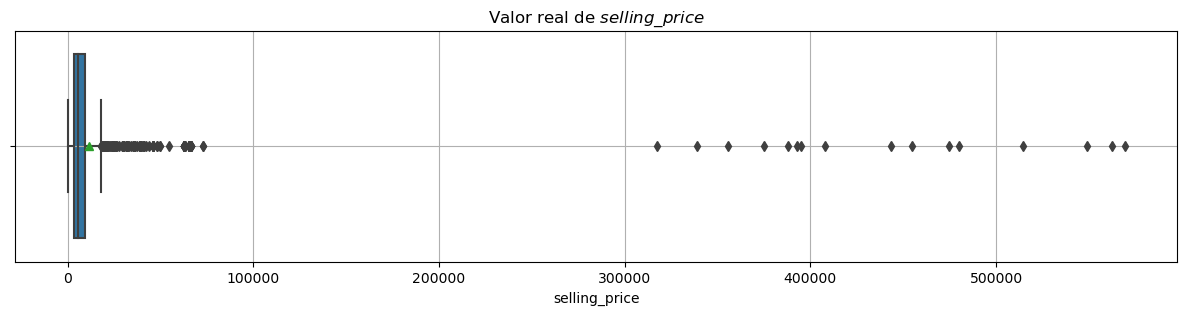

In [34]:
plt.figure(figsize = (15, 3))
sns.boxplot(x = y_test, showmeans = True, orient = 'h')
plt.title('Valor real de $\t{selling\_price}$')
plt.grid()
plt.show()

## 6. Entrenamiento 3er Modelo
Para este tercer modelo se plantea usar metodos de normalización con tal de llegar a quitar el efecto de los valores atipicos del modelo.

In [35]:
data_tercer_modelo = df_vehiculos_copy.copy()
def normalize_cols(df, var_to_transform):
    scaler = MinMaxScaler()

    arr_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(arr_scaled, columns=df.columns,index=df.index)

    return df_scaled

        

In [36]:
norm_data=normalize_cols(data_tercer_modelo,variables_interes)
norm_data.sample(5)

,Unnamed: 0,year,km_driven,owner,seller_type,seats,fuel,transmission,mileage,engine,max_power,selling_price
3138,0.441737,0.538462,0.025418,0.8,0.5,0.25,1.000000,1.0,0.320403,0.642929,0.032854,0.003132
665,0.094377,0.807692,0.038763,0.4,0.5,0.25,0.333333,1.0,0.512645,0.002354,0.034559,0.008593
5651,0.794881,0.807692,0.011226,0.0,0.5,0.25,1.000000,1.0,0.485731,0.039663,0.023178,0.005053
2910,0.410237,0.576923,0.042364,0.0,0.5,0.25,1.000000,1.0,0.420796,0.039663,0.669287,0.002323
6316,0.888889,0.576923,0.093202,0.0,0.5,0.50,0.333333,1.0,0.273411,0.124700,0.050602,0.012133


In [37]:
x_train, y_train  = norm_data[variables_interes], df_vehiculos_transformed['selling_price']
x_train.shape, y_train.shape

((7115, 10), (7115,))

In [38]:
regression_3 = LinearRegression()
regression_3.fit(x_train, y_train)
regression_3.intercept_

8714.733091500748

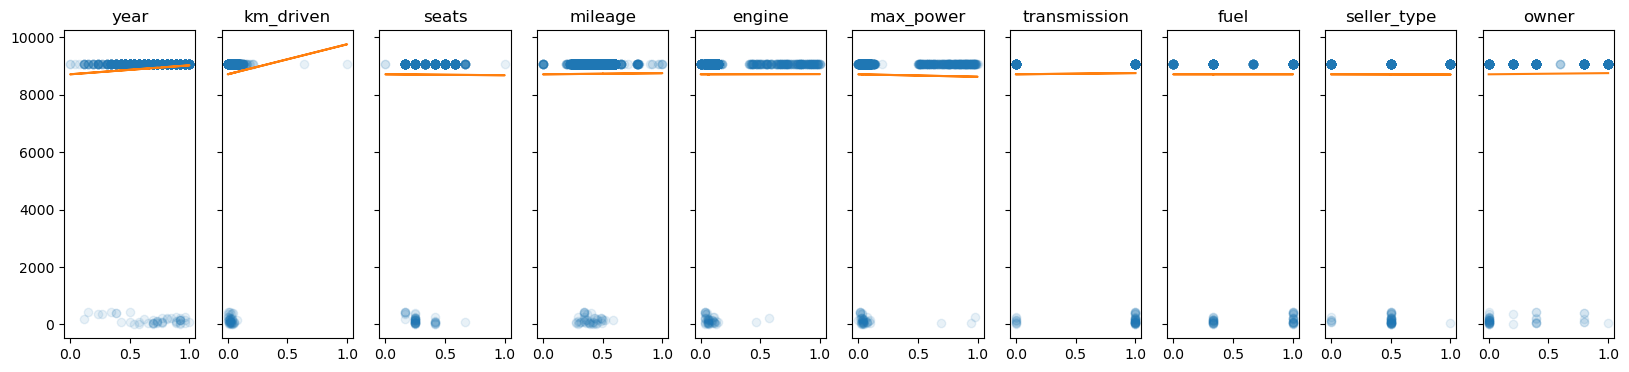

In [39]:
f, axs = plt.subplots(1, len(variables_interes), sharey = True, figsize = (20, 4))

for i in range(len(variables_interes)):
    col = variables_interes[i]
    x = x_train[col]
    m = regression_3.coef_[i]
    b = regression_3.intercept_

    axs[i].plot(x, y_train, 'o', alpha = 0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
plt.show()

In [40]:
pd.DataFrame({'columns': variables_interes, 'coef': regression_3.coef_})

,columns,coef
0,year,312.414300
1,km_driven,1046.752862
2,seats,-32.286649
3,mileage,39.336137
4,engine,7.972957
5,max_power,-84.828868
6,transmission,43.047939
7,fuel,0.200299
8,seller_type,-8.785695
9,owner,41.551046


### 5.2 Validación 2do Modelo


#### Mean Absolute Error

In [48]:
print('Train:', mean_absolute_error(y_train, regression_2.predict(x_train)))
print('Test:', mean_absolute_error(y_test, regression_2.predict(x_test)))

Train: 1157449.007694714
Test: 8609.721337252493


In [49]:
 print('Train:', np.sqrt(mean_squared_error(y_train, regression_2.predict(x_train))))
print('Test:', np.sqrt(mean_squared_error(y_test, regression_2.predict(x_test))))

Train: 1157459.2855003835
Test: 38255.19509447831


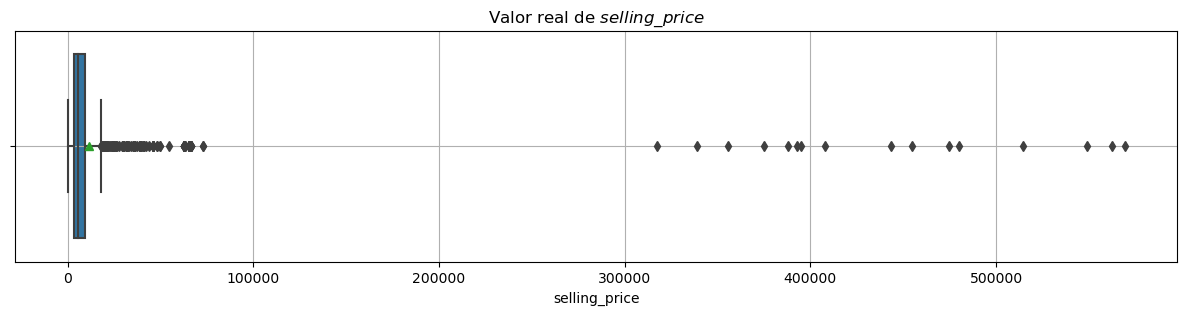

In [50]:
plt.figure(figsize = (15, 3))
sns.boxplot(x = y_test, showmeans = True, orient = 'h')
plt.title('Valor real de $\t{selling\_price}$')
plt.grid()
plt.show()

## 7.Entrenamiento 4to Modelo 

In [51]:
data_cuarto_modelo = df_vehiculos_copy.copy()
def scale_data(df):
    ss = StandardScaler()
    df_scaled = pd.DataFrame(ss.fit_transform(df),columns = df.columns)
    return df_scaled

    


In [56]:
norm_data=normalize_cols(data_cuarto_modelo,variables_interes)
norm_data.sample(5)

,Unnamed: 0,year,km_driven,owner,seller_type,seats,fuel,transmission,mileage,engine,max_power,selling_price
148,0.020918,0.884615,0.012709,0.0,0.5,0.166667,1.000000,0.0,0.897129,0.098407,0.200008,0.202262
2218,0.312908,0.692308,0.027113,0.0,0.5,0.250000,0.333333,1.0,0.352871,0.099509,0.061482,0.008087
1534,0.216316,0.846154,0.033891,0.0,0.5,0.250000,0.333333,1.0,0.551734,0.074820,0.049098,0.007622
6134,0.863295,0.538462,0.016945,0.4,0.5,0.250000,1.000000,1.0,0.388756,0.052935,0.031551,0.003031
1727,0.242771,0.423077,0.059310,0.4,0.5,0.250000,1.000000,1.0,0.403708,0.049780,0.033105,0.018797


In [57]:
regression_4 = LinearRegression()
regression_4.fit(x_train, y_train)
regression_4.intercept_

8714.733091500748

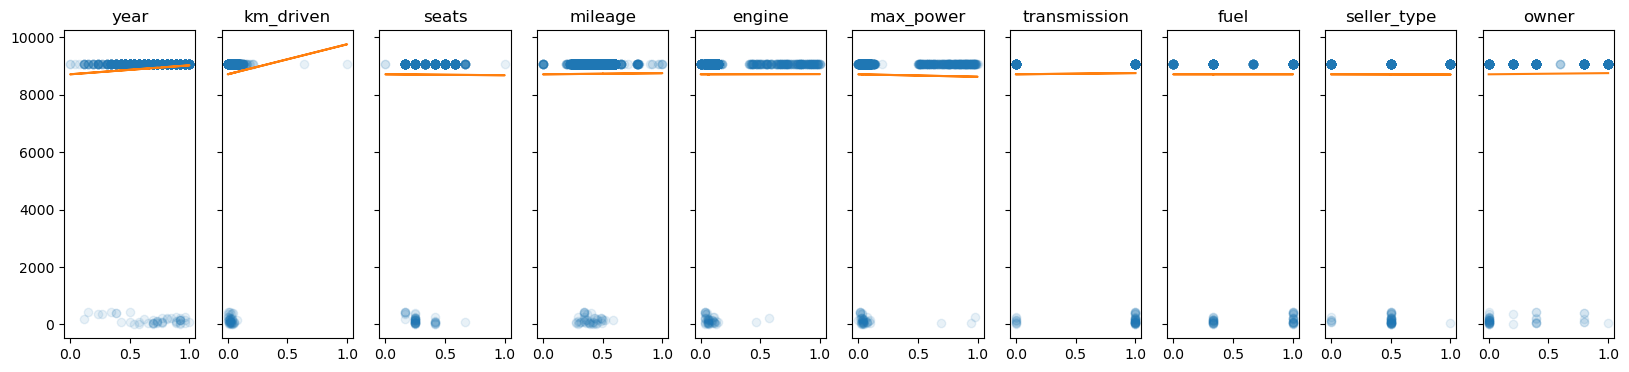

In [58]:
f, axs = plt.subplots(1, len(variables_interes), sharey = True, figsize = (20, 4))

for i in range(len(variables_interes)):
    col = variables_interes[i]
    x = x_train[col]
    m = regression_3.coef_[i]
    b = regression_3.intercept_

    axs[i].plot(x, y_train, 'o', alpha = 0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
plt.show()

In [59]:
pd.DataFrame({'columns': variables_interes, 'coef': regression_3.coef_})

,columns,coef
0,year,312.414300
1,km_driven,1046.752862
2,seats,-32.286649
3,mileage,39.336137
4,engine,7.972957
5,max_power,-84.828868
6,transmission,43.047939
7,fuel,0.200299
8,seller_type,-8.785695
9,owner,41.551046


## 7. Entrenamiento 4to Modelo

Para este segundo modelo se va a aplicar metodos de normalización con tal 

In [41]:
pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]
)

In [45]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [46]:
pd.DataFrame({'columns': variables_interes, 'coef': pipeline['model'].coef_})

,columns,coef
0,year,45.504715
1,km_driven,25.342864
2,seats,-2.565410
3,mileage,3.513699
4,engine,0.925055
5,max_power,-11.470693
6,transmission,14.629133
7,fuel,0.066924
8,seller_type,-1.755162
9,owner,11.687091


In [47]:
pipeline['model'].intercept_

9028.74262122277